# Analisis de caracteristicas
Este análisis tiene como objetivo preparar los datos de ventas de una empresa de retail mediante técnicas de ingeniería de características, facilitando la predicción de inversión en productos de temporada y la gestión óptima de inventarios. La limpieza y transformación de los datos tiene como utilidad eliminar ruido y reducir complejidad.

In [103]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder,  PowerTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, mutual_info_regression
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

Se cargaron los datos desde un archivo Excel y se eliminaron columnas duplicadas y redundantes, como las que contenían sufijos .1 y las columnas Unnamed, para evitar inconsistencias y simplificar el análisis.

In [104]:
# Cargar el archivo Excel
file_path = "./subclase_1153.xlsx"
xls = pd.ExcelFile(file_path)

# Ver las hojas disponibles en el archivo
print(xls.sheet_names)

['pronostico', 'Sheet1', 'cluster 1-6', 'cluster 1-7', 'label_pronostico', 'label_tienda']


In [105]:
# Cargamos las hojas de los clusters
df_6 = xls.parse("cluster 1-6").iloc[:16830] # Solo tenemos entradas hasta la fila 16830
df_7 = xls.parse("cluster 1-7")



# Combinar ambos datasets
df = pd.concat([df_6, df_7], ignore_index=True)

# Eliminamos las columna redundantes

# Eliminar columnas con sufijo .1
df = df.loc[:, ~df.columns.str.endswith('.1')]

# Eliminar columnas 'Unnamed'
df = df.loc[:, ~df.columns.str.contains('Unnamed')]

In [106]:
# Características iniciales
# 'subclase_id', 'label_producto', 'label_tienda', 'pronostico_id', 'venta_mensual',
# 'precio_cat', 'año', 'mes', 'precio_mensual', 'volumen_mensual', 'venta_costo_mensual', 
# 'year', 'costo_prov', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11',
# 'm12', 'trimestre', 'T2', 'T3', 'T4'

# Eliminamos identificadores irrelevantes
# Dado que el mes ya lo tenemos como one hot encoding
# El pronostico lo vamos a generar nosotros
# Eliminamos columnas de trimestres por redundancia con los meses
df.drop(['pronostico_id', 'mes','trimestre', 'T2', 'T3', 'T4'], axis=1, inplace=True)

## Visualizacion de matriz de correlacion

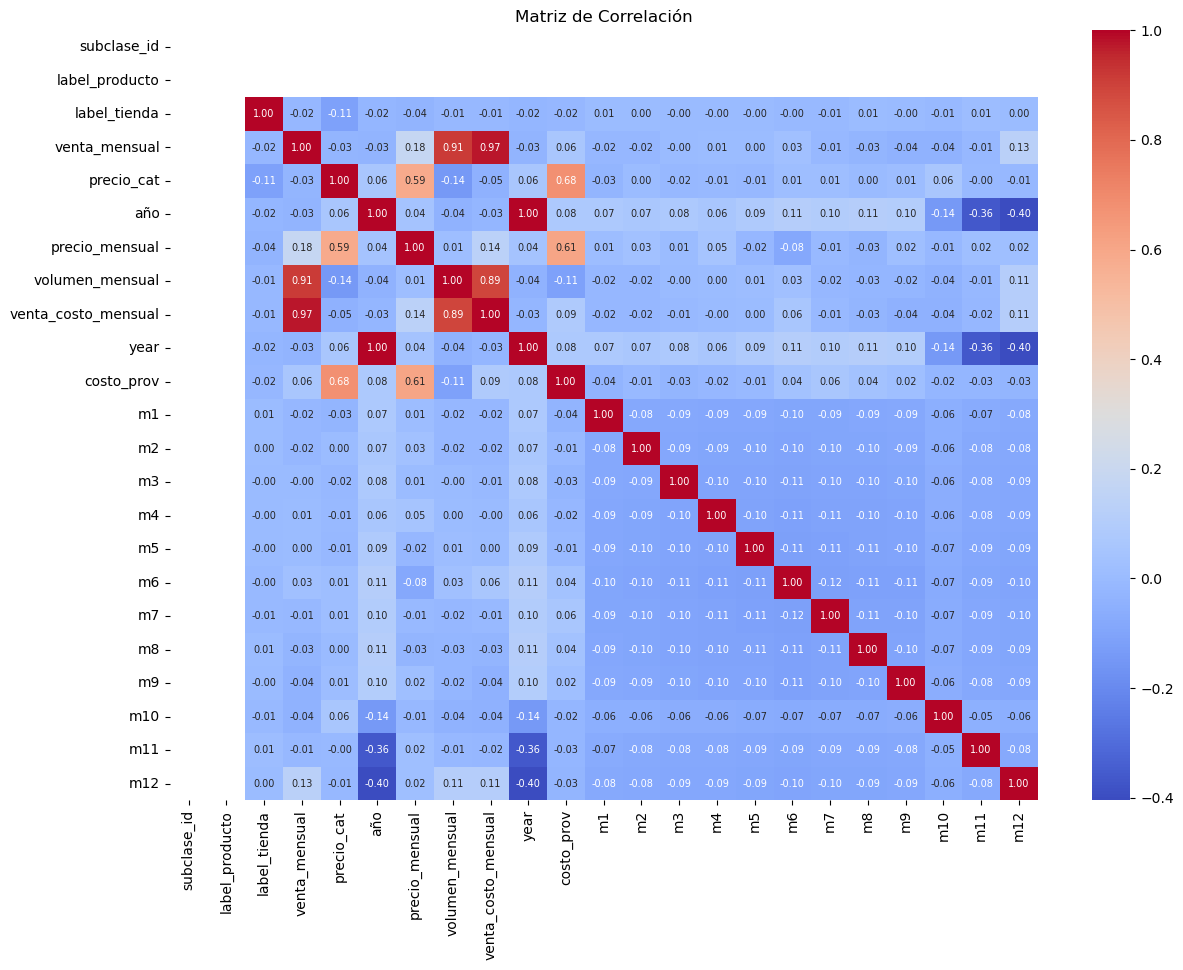

In [107]:
# Análisis de correlación con mejor visualización
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 7})
plt.title('Matriz de Correlación')
plt.show()

## Observaciones

### Correlaciones fuertes:

venta_mensual tiene una correlación muy alta con volumen_mensual y venta_costo_mensual, lo cual tiene sentido, ya que el volumen de productos vendidos y el costo total de ventas están directamente relacionados con las ventas mensuales.
precio_mensual también muestra una correlación moderada con venta_mensual y volumen_mensual, lo que indica que los precios influyen en el volumen de ventas.

### Correlaciones moderadas:

precio_cat tiene una correlación moderada con costo_prov y precio_mensual, lo cual sugiere que categorías de precios están ligadas a los costos de proveedores.
Las variables binarias de meses (m1, m2, ..., m12) muestran correlaciones muy bajas con venta_mensual, lo que podría indicar que las ventas no tienen una estacionalidad muy marcada o que esta no está capturada adecuadamente. Para mi esto fue inesperado ya que realmente esperaba una correlacion entre ventas y mes.

## Generación de nuevas características:
Se creó la variable costo_venta_ratio para capturar la relación entre costos y ventas. Esto puede ser clave para identificar productos más rentables. 

In [108]:
# Relaciona el costo total con las ventas mensuales para entender la rentabilidad de cada producto.
df['costo_venta_ratio'] = df['venta_costo_mensual'] / df['venta_mensual']

In [109]:
# Permite identificar productos con márgenes de beneficio más altos
df['margen_ganancia'] = (df['venta_mensual'] - df['venta_costo_mensual']) / df['venta_mensual']

In [110]:
#  Mide el impacto de los cambios en el precio sobre el volumen de ventas.
df['elasticidad_precio'] = df['volumen_mensual'] / df['precio_mensual']

In [111]:
# Permite capturar tendencias y variaciones en la demanda.
df['tasa_crecimiento_ventas'] = df['venta_mensual'].pct_change()

/var/folders/r1/bng466016psds6vp1_qcrgk40000gn/T/ipykernel_23910/208165423.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['tasa_crecimiento_ventas'] = df['venta_mensual'].pct_change()


## Normalización y Transformación
- Se aplicó StandardScaler para garantizar que todas las variables numéricas tengan la misma escala y evitar sesgos en los modelos.
- Se aplicó la transformación Box-Cox para estabilizar la varianza y mejorar la normalidad de las distribuciones de algunas variables clave.


In [112]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

scaler = StandardScaler()
df[['venta_mensual', 'precio_mensual', 'volumen_mensual']] = scaler.fit_transform(df[['venta_mensual', 'precio_mensual', 'volumen_mensual']])


In [113]:
pt = PowerTransformer(method='yeo-johnson')
df[['venta_mensual', 'precio_mensual', 'volumen_mensual']] = pt.fit_transform(df[['venta_mensual', 'precio_mensual', 'volumen_mensual']])

## Codificaciones:
 Usamos One-Hot Encoding para convertir label_tienda en un formato numérico adecuado para el entrenamiento de modelos, evitando la introducción de un orden arbitrario.

In [114]:
# Codificación One-Hot para label_tienda
df = pd.get_dummies(df, columns=['label_tienda'], drop_first=True)

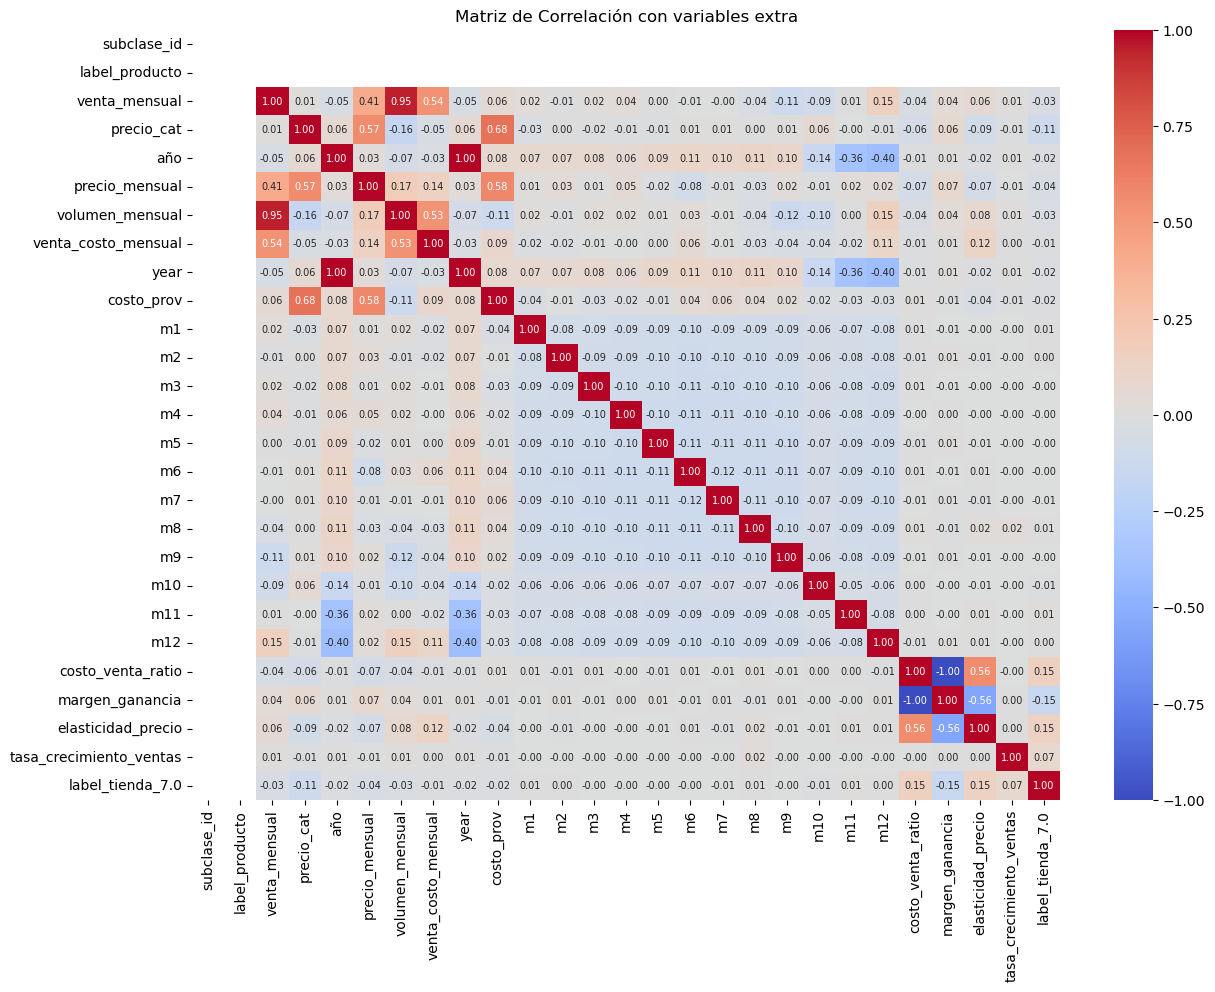

In [115]:
# Visualización de efectos
# Análisis de correlación con mejor visualización
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 7})
plt.title('Matriz de Correlación con variables extra')
plt.show()

## Selección y Extracción de Características
- Se identificaron y eliminaron variables que presentan una varianza muy baja, lo que indica que no aportan información significativa.

In [116]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)
df = df.loc[:, selector.fit(df).get_support()]

In [117]:
#Renombramos la columna label_tienda_7.0
df.rename(columns={'label_tienda_7.0': 'label_tienda'}, inplace=True)
df.columns


Index(['venta_mensual', 'precio_cat', 'año', 'precio_mensual',
       'volumen_mensual', 'venta_costo_mensual', 'year', 'costo_prov', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'costo_venta_ratio', 'margen_ganancia', 'elasticidad_precio',
       'tasa_crecimiento_ventas', 'label_tienda'],
      dtype='object')

In [118]:
# Guardamos el dataset transformado
df.to_csv('datos_retail_transformed.csv', index=False)